<a href="https://colab.research.google.com/github/HCDS21/soybean_time_series_analysis/blob/main/tsa_poscovid_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U kaleido
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.rcmod import axes_style

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Carga de dados

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/arima_2.0/dados preenchidos_v2.xlsx")

df['data'] = pd.to_datetime(df['data'])


In [ ]:
df = df[['data','real']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    731 non-null    datetime64[ns]
 1   real    731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


# Data wrangling - Pre covid

In [ ]:
poscovid = df[df['data'].gt('2020-03-10') & df['data'].lt('2021-03-11')].reset_index(drop=True)


## Separação da base de dados em treino e teste

In [ ]:
poscovid_train = poscovid[0:292]
poscovid_test = poscovid[292:365]


# Verificação da estacionalidade dos dados

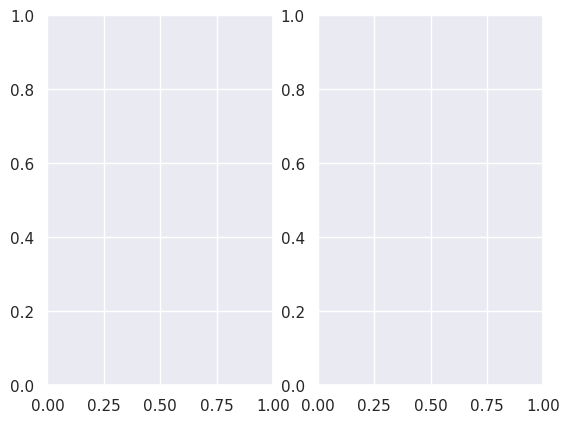

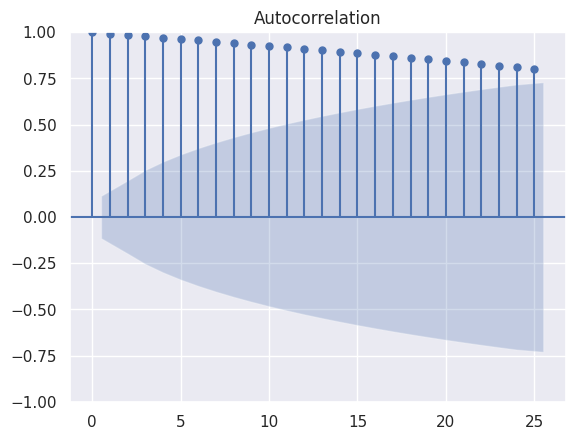

In [ ]:
#Verificando por medio da ACF
sns.set(style="darkgrid")
f, (axs) = plt.subplots(1,2)
#f = plt.figure()
plot_acf(poscovid_train['real'].dropna())
#plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/pac_poscovid_treino.png')
plt.show()

O grafico da ACF mostra uma queda praticamente nula ao longo dos lags o que da um forte indicio de que a serie não é estacionaria.

Vamos utilizar o teste Dickey-Fuller, o teste verificara se a série é ou não estacionaria a partir da hipotese:

H0 = A série é não estacionaria

H1 = Há fortes indicios estatisticos de que a serie é estacionaria.

In [ ]:
def adfuller_test(teste):
    result=adfuller(teste)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [ ]:
adfuller_test(poscovid_train['real'])

ADF Test Statistic : -1.3437234418853963
p-value : 0.6089391310522717
#Lags Used : 1
Number of Observations Used : 290
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
kpss_test(poscovid_train['real'])

Results of KPSS Test:
Test Statistic            2.581747
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Diferenciando a série para torná-la estacionaria

In [ ]:
poscovid_train['primeira_deriv'] = poscovid_train['real'].diff(1)
poscovid_train['segunda_deriv'] = poscovid_train['real'].diff(2)
poscovid_train['terceira_deriv'] = poscovid_train['real'].diff(3)


<ipython-input-12-5aed88805ce0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poscovid_train['primeira_deriv'] = poscovid_train['real'].diff(1)
<ipython-input-12-5aed88805ce0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poscovid_train['segunda_deriv'] = poscovid_train['real'].diff(2)
<ipython-input-12-5aed88805ce0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

###Primeira derivada

In [ ]:
adfuller_test(poscovid_train['primeira_deriv'].dropna())
#kpss test testar

ADF Test Statistic : -20.36740811325065
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 290
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [ ]:
kpss_test(poscovid_train['primeira_deriv'].dropna())

Results of KPSS Test:
Test Statistic           0.269295
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


False


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


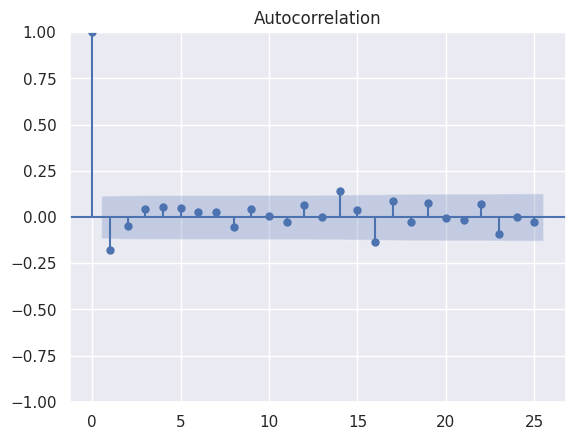

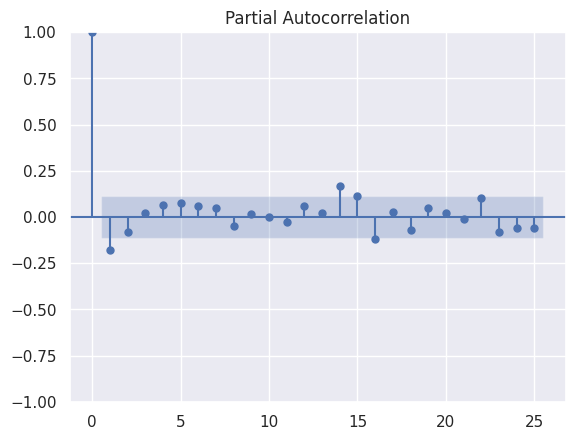

In [ ]:
acf_diff = plot_acf(poscovid_train['primeira_deriv'].dropna())
pacf_diff = plot_pacf(poscovid_train['primeira_deriv'].dropna())
print(acf_diff == pacf_diff)

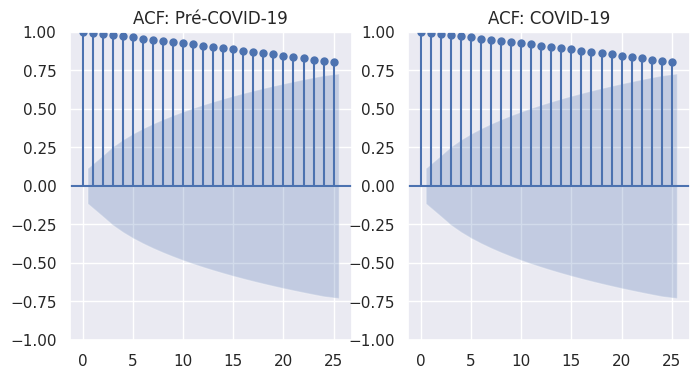

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))

plot_acf(poscovid_train['real'], ax=ax1)
ax1.set_title('ACF: Pré-COVID-19')
plot_acf(poscovid_train['real'], ax=ax2)
ax2.set_title('ACF: COVID-19')
#plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/acf_inicial.png')
fig.show()

In [ ]:
modelos = pd.DataFrame(columns=['modelo','aic'])

In [ ]:
p = 0
d = 0
q=0
modelo = 0
contador =0
m = 0
order=0
modelo=0

for ar in range (0,5):
  p = ar
  for i in range(1,3):
    d = i
    for ma in range(0,5):
      q = ma
      vetor=[]
      order=(p,d,q)
      vetor.append(order)
      modelo = ARIMA(poscovid_train['real'], order= order)
      m = modelo.fit()
      vetor.append(round(m.aic,3))
      modelos.loc[contador] = vetor
      print('modelo:','(',p,d,q,')', '#:',contador, 'vetor:', vetor)
      contador= contador + 1


modelo: ( 0 1 0 ) #: 0 vetor: [(0, 1, 0), 1110.61]
modelo: ( 0 1 1 ) #: 1 vetor: [(0, 1, 1), 1104.315]
modelo: ( 0 1 2 ) #: 2 vetor: [(0, 1, 2), 1106.31]
modelo: ( 0 1 3 ) #: 3 vetor: [(0, 1, 3), 1105.952]
modelo: ( 0 1 4 ) #: 4 vetor: [(0, 1, 4), 1105.032]
modelo: ( 0 2 0 ) #: 5 vetor: [(0, 2, 0), 1352.213]
modelo: ( 0 2 1 ) #: 6 vetor: [(0, 2, 1), 1111.111]
modelo: ( 0 2 2 ) #: 7 vetor: [(0, 2, 2), 1099.556]
modelo: ( 0 2 3 ) #: 8 vetor: [(0, 2, 3), 1100.713]
modelo: ( 0 2 4 ) #: 9 vetor: [(0, 2, 4), 1102.06]
modelo: ( 1 1 0 ) #: 10 vetor: [(1, 1, 0), 1104.872]
modelo: ( 1 1 1 ) #: 11 vetor: [(1, 1, 1), 1106.312]
modelo: ( 1 1 2 ) #: 12 vetor: [(1, 1, 2), 1100.05]
modelo: ( 1 1 3 ) #: 13 vetor: [(1, 1, 3), 1100.947]
modelo: ( 1 1 4 ) #: 14 vetor: [(1, 1, 4), 1105.059]
modelo: ( 1 2 0 ) #: 15 vetor: [(1, 2, 0), 1247.378]
modelo: ( 1 2 1 ) #: 16 vetor: [(1, 2, 1), 1102.053]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


modelo: ( 1 2 2 ) #: 17 vetor: [(1, 2, 2), 1100.977]
modelo: ( 1 2 3 ) #: 18 vetor: [(1, 2, 3), 1102.46]
modelo: ( 1 2 4 ) #: 19 vetor: [(1, 2, 4), 1104.516]
modelo: ( 2 1 0 ) #: 20 vetor: [(2, 1, 0), 1105.848]
modelo: ( 2 1 1 ) #: 21 vetor: [(2, 1, 1), 1107.666]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 2 1 2 ) #: 22 vetor: [(2, 1, 2), 1093.503]
modelo: ( 2 1 3 ) #: 23 vetor: [(2, 1, 3), 1102.753]
modelo: ( 2 1 4 ) #: 24 vetor: [(2, 1, 4), 1104.78]
modelo: ( 2 2 0 ) #: 25 vetor: [(2, 2, 0), 1192.675]
modelo: ( 2 2 1 ) #: 26 vetor: [(2, 2, 1), 1100.26]
modelo: ( 2 2 2 ) #: 27 vetor: [(2, 2, 2), 1102.182]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 2 2 3 ) #: 28 vetor: [(2, 2, 3), 1094.628]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 2 2 4 ) #: 29 vetor: [(2, 2, 4), 1100.489]
modelo: ( 3 1 0 ) #: 30 vetor: [(3, 1, 0), 1107.263]
modelo: ( 3 1 1 ) #: 31 vetor: [(3, 1, 1), 1100.684]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


modelo: ( 3 1 2 ) #: 32 vetor: [(3, 1, 2), 1102.511]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 3 1 3 ) #: 33 vetor: [(3, 1, 3), 1097.503]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 3 1 4 ) #: 34 vetor: [(3, 1, 4), 1106.682]
modelo: ( 3 2 0 ) #: 35 vetor: [(3, 2, 0), 1162.01]
modelo: ( 3 2 1 ) #: 36 vetor: [(3, 2, 1), 1102.138]
modelo: ( 3 2 2 ) #: 37 vetor: [(3, 2, 2), 1104.102]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 3 2 3 ) #: 38 vetor: [(3, 2, 3), 1093.833]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 3 2 4 ) #: 39 vetor: [(3, 2, 4), 1103.262]
modelo: ( 4 1 0 ) #: 40 vetor: [(4, 1, 0), 1107.176]
modelo: ( 4 1 1 ) #: 41 vetor: [(4, 1, 1), 1102.432]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


modelo: ( 4 1 2 ) #: 42 vetor: [(4, 1, 2), 1104.414]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 4 1 3 ) #: 43 vetor: [(4, 1, 3), 1106.06]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 4 1 4 ) #: 44 vetor: [(4, 1, 4), 1098.541]
modelo: ( 4 2 0 ) #: 45 vetor: [(4, 2, 0), 1143.912]
modelo: ( 4 2 1 ) #: 46 vetor: [(4, 2, 1), 1103.962]
modelo: ( 4 2 2 ) #: 47 vetor: [(4, 2, 2), 1106.042]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


modelo: ( 4 2 3 ) #: 48 vetor: [(4, 2, 3), 1095.976]
modelo: ( 4 2 4 ) #: 49 vetor: [(4, 2, 4), 1098.094]


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
modelos = modelos.sort_values('aic', ascending=True).reset_index(drop=True)

In [ ]:
model = ARIMA(poscovid_train['real'], order=modelos.loc[0][0], trend='t')
mfit = model.fit()

model1 = ARIMA(poscovid_train['real'], order=modelos.loc[1][0])
mfit1 = model1.fit()

model2 = ARIMA(poscovid_train['real'], order=modelos.loc[2][0])
mfit2 = model2.fit()

print(mfit.summary())


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   real   No. Observations:                  292
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -539.167
Date:                Sat, 15 Apr 2023   AIC                           1090.333
Time:                        07:44:50   BIC                           1112.373
Sample:                             0   HQIC                          1099.163
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1951      0.089      2.186      0.029       0.020       0.370
ar.L1          1.1810      0.032     37.461      0.000       1.119       1.243
ar.L2         -0.8784      0.035    -25.158      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


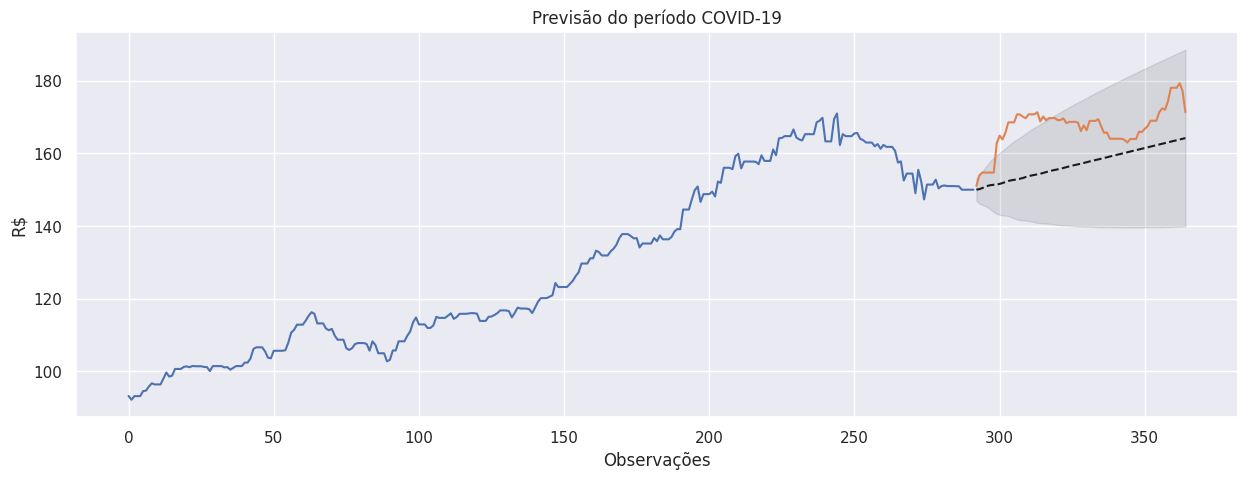

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
poscovid_train['real'].plot(ax=ax)
poscovid_test['real'].plot(ax=ax)

plt.title('Previsão do período COVID-19')
plt.ylabel('R$')
plt.xlabel('Observações')

fcast = mfit.get_forecast(len(poscovid_test['real'])).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.savefig('/content/drive/MyDrive/A-TCC DSA/Hector Jose Cervellon Urrutia/Analise_soja/imagens/previsao_covid.png')
#fazer uma tabela que faça para 1, 2, 3 .... todos dados da bd e que mostre o mape

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
poscovid['real'].plot(ax=ax)

fcast1 = mfit1.get_forecast(len(poscovid_test['real'])).summary_frame()
fcast1['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast1.index, fcast1['mean_ci_lower'], fcast1['mean_ci_upper'], color='k', alpha=0.1)

#fazer uma tabela que faça para 1, 2, 3 .... todos dados da bd e que mostre o mape'''

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
poscovid['real'].plot(ax=ax)

fcast2 = mfit2.get_forecast(len(poscovid_test['real'])).summary_frame()
fcast2['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast2.index, fcast2['mean_ci_lower'], fcast2['mean_ci_upper'], color='k', alpha=0.05)
#fazer uma tabela que faça para 1, 2, 3 .... todos dados da bd e que mostre o mape'''

# Predict de datos

In [ ]:
ypredict = mfit.predict()

In [ ]:
frames = [poscovid_train['real'],ypredict]
result = pd.concat(frames, axis=1)
fig = px.line(result)
fig.show()

## Residuo e densidade das predições

In [ ]:
residuals = mfit.resid[1:]
fig, ax = plt.subplots(nrows=1,ncols=2)
residuals.plot(title='Residuos modelo 1', ax=ax[0])
residuals.plot(title='Densidade',kind='kde', ax=ax[1])

plt.show()

In [ ]:
acf_res1 = plot_acf(residuals)
pacf_res1 = plot_pacf(residuals)

# Forecast

In [ ]:
forecast = mfit.forecast(len(poscovid_test))
poscovid['forecast'] = [None]*len(poscovid_train) + list(forecast)
poscovid['get_forecast'] = [None]*len(poscovid_train) + list(fcast['mean']) + ([None]*(365 - (len(poscovid_train) + len(fcast['mean']))))


In [ ]:
poscovid1 = poscovid
poscovid1 

In [ ]:
poscovid1.loc[290:293]['get_forecast'].plot(figsize=(30,10))

In [ ]:
poscovid1.loc[291:365]

# Auto Arima

In [ ]:

import pmdarima as pm

In [ ]:
auto_arima = pm.auto_arima(poscovid_train['real'], stepwise=False, seasonal=False, trend='t')
auto_arima

In [ ]:
print(auto_arima.summary())

In [ ]:
forecast_auto = auto_arima.predict(n_periods=len(poscovid_test))
poscovid['auto'] = [None]*len(poscovid_train) + list(forecast_auto)
poscovid1 = poscovid


In [ ]:
poscovid.iloc[290:366][['real','get_forecast','auto']].plot()

#Metricas de Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Predict

In [ ]:
mae1 = mean_absolute_error(poscovid_train['real'],ypredict)
mape1 = mean_absolute_percentage_error(poscovid_train['real'],ypredict)
rmse1 = np.sqrt(mean_squared_error(poscovid_train['real'],ypredict))
print(f' mae1: {round(mae1,4)}, mape1: {round(mape1,4)}, rmse1: {round(rmse1,4)}')


In [ ]:
mae1 = mean_absolute_error(poscovid_test['real'],poscovid1.loc[292:365]['get_forecast'])
mape1 = mean_absolute_percentage_error(poscovid.loc[292:365]['real'],poscovid1.loc[292:365]['get_forecast'])
rmse1 = np.sqrt(mean_squared_error(poscovid.loc[292:365]['real'],poscovid1.loc[292:365]['get_forecast']))
print(f' mae1: {round(mae1,4)}, mape1: {round(mape1,4)}, rmse1: {round(rmse1,4)}')


## Forecast

In [ ]:
fcast1 =fcast
fcast1 = fcast1.reset_index(drop=True)
fcast1

In [ ]:
mae1 = mean_absolute_error(poscovid_test['real'],fcast1['mean'])
mape1 = mean_absolute_percentage_error(poscovid_test['real'],fcast1['mean'])*100
rmse1 = (mean_squared_error(poscovid_test['real'],fcast1['mean']))
print(f' mae1: {round(mae1,4)}, mape1: {round(mape1,4)}, rmse1: {round(rmse1,4)}')

mae = mean_absolute_error(poscovid_test['real'],forecast_auto)
mape = mean_absolute_percentage_error(poscovid_test['real'],forecast_auto)
rmse = np.sqrt(mean_squared_error(poscovid_test['real'],forecast_auto))
print(f' mae_auto: {round(mae,4)}, mape_auto: {round(mape,4)}, rmse_auto: {round(rmse,4)}')

In [ ]:
sum(abs(poscovid_test['real']- fcast1['mean']))/73

In [ ]:
sum(abs(poscovid_test['real']- fcast1['mean'])/poscovid_test['real'])*100/73

In [ ]:
sum((poscovid_test['real']- fcast1['mean'])**2)/73